<a href="https://colab.research.google.com/github/pwolscho/unet/blob/master/u_net_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![U-Net Demonstration](https://drive.google.com/uc?id=1-kEr1EjJgpSjGCV1oFfYw_A2cnu5cNVI)

#Über dieses Notebook

U-Net ist die bekannteste Architektur im Bereich der Semantischen Segmentierung (Anwendung: Segmentierung in Bildern). Im Rahmen des Kurses Seminat-Deep-Learning der Hochschule Offenburg zeigt dieses Notebook eine mögliche Implementierung von U-Net und demonstriert dessen Anwendung anhand eines Beispiel-Datensatzes.

Informationen zum Datensatz
Mehrere Gebiete der Erde mit großen Öl- und Gasansammlungen haben auch riesige Salzlagerstätten unter der Oberfläche, d.h. dort wo Salz ist, wird vermutlich auch das wertvolle Öl zu finden sein.

Professionelle seismische Messungen zum Auffinden der Salzlagerstätten erfordert immer noch eine fachkundige menschliche Interpretation der daraus resultierenden Bilddaten. Dies führt zu sehr subjektiven, sehr variablen Ergebnissen. Das führt zu potenziell gefährlichen Situationen für Bohrer von Öl- und Gasunternehmen.

Um sehr präzise seismischen Bilder zu erstellen, hofft TGS-NOPEC Geophysical Systems (das weltweit führende Unternehmen für geophysikalische Dienste), dass die Online-Community von Kaggle in der Lage sein wird, einen Algorithmus zu entwickeln, der automatisch und genau erkennt, ob und Salz unter der Erdoberfläche zu finden ist oder nicht.

Dazu wurde im Jahr 2018 eine Wettbewerb von Kaggle durchgeführt.

Auf den diesem Notebook verwendete Datensatz kann nach wie vor unter https://www.kaggle.com/c/tgs-salt-identification-challenge/data zugegriffen werden.

Die Daten sind eine Reihe von seismischen Bildern von zufällig ausgewählten Orten der Erde. Die Bilder sind 101 x 101 Pixel groß und jedes Pixel wird entweder als Salz oder als Sediment klassifiziert. Zusätzlich zu den seismischen Bildern wird für jedes Bild die Tiefe der aufgenommenen Position angegeben.

##Gliederung des Notebooks

Die durchgeführten Schritte gliedern sich chronologisch wie folgt:

- Bereitstellung des Datensatzes
  - Zugriff auf die Kaggle-API
  - Download und Entpacken des Datensatzes
  - Skalierung der Trainigsbilder und Masken
- Definition des U-Net-Modells
- Training des U-Net-Modells
- Evaluierung des U-Net-Modells

#Bereitstellung des Datensatzes

##Zugriff auf die Kaggle-API

Um auf den Datensatz von Kaggle zugreifen zu können, wird die Kaggle-API (https://www.kaggle.com/docs/api) und einen persönlichen API-Token benötigt. Der API-Token kann im persönlichen Account von Kaggle generiert werden. Um den manuellen Upload (files.upload()) zu umgehen wird der Inhalt des Tokens hartkodiert.

In [0]:
kaggle_json = '{"username":"philipwolschon","key":"715ad801ca6728d6730b7c276db32c6f"}'

In [0]:
Zunächst wird die leere Datei kaggle.json angelegt und mit dem Inhalt des kaggle_json-Objekts (API-Token) befüllt.

In [0]:
with open('kaggle.json', 'w') as file:
  json.dump(kaggle_json, file, ensure_ascii=False)

with open('kaggle.json', 'w') as file:
  file.write(kaggle_json)

Außerdem erwartet die Kaggle-API, dass der API-Token in ~/.kaggle/ (/root/.kaggle/) zu finden ist. Daher wird das Verzeichnis "kaggle" erstellt und der API-Token dort hin verschoben.

In [6]:
!pip install kaggle #Zugriff auf den Datensatz von Kaggle

In [0]:
!mkdir -p ~/.kaggle #Den Ordner anlegen
!mv kaggle.json ~/.kaggle/ #Den API-Token verschieben

Liefert folgende Funktion True zurück wurde die erforderliche Datei im korrekten Verzeichnis der VM erstellt (eine manuelle Prüfung ist nicht möglich, da der Zugriff auf das root-Verzeichnis der VM eingeschränkt ist).

In [0]:
import os

In [10]:
os.path.isfile("/root/.kaggle/kaggle.json")

True

Um Warnungen beim Starten von Kaggle-Tools zu vermeiden werdem dem Besitzer der Datei Lese- und Schreibrechte gewährt.

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

##Download und Entpacken des Datensatzes

Mit Hilfe der Kaggle-API kann nun das Datenset heruntergeladen werden.

In [13]:
!kaggle competitions download -c tgs-salt-identification-challenge -p /content/salt_data

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 104MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 83.5MB/s]
 91% 197M/217M [00:01<00:00, 170MB/s]
100% 217M/217M [00:01<00:00, 185MB/s]
 66% 25.0M/37.9M [00:00<00:00, 37.5MB/s]
100% 37.9M/37.9M [00:00<00:00, 55.1MB/s]
 92% 38.0M/41.4M [00:00<00:00, 81.0MB/s]
100% 41.4M/41.4M [00:00<00:00, 203MB/s] 
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 127MB/s]
 96% 156M/163M [00:01<00:00, 115MB/s]
100% 163M/163M [00:01<00:00, 147MB/s]


Die Trainigs- und Testdaten sind komprimiert und müssen zunächst entpackt werden.

In [0]:
from zipfile import ZipFile

In [0]:
#Entpacken der Testdaten
with ZipFile('/content/salt_data/test.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/test')
   
#Entpacken der Trainingsdaten
with ZipFile('/content/salt_data/train.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/train')

In [0]:
train_path = '/content/salt_data/train'

##Skalierung der Trainigsbilder und Masken

In [31]:
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [0]:
def get_scaled_X_y_data(path, img_width, img_height):
    output_shape = (128, 128, 1) #Size of the generated output image (rows, cols[, …][, dim])

    ids = os.listdir(path + '/images')
    X = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    y = np.zeros((len(ids), img_height, img_width, 1), dtype=np.float32)
    print('Getting and resizing images ... ')

    for n, id_ in tqdm(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path + '/images/' + id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, output_shape, mode='constant', preserve_range=True)

        # Load masks
        mask = img_to_array(load_img(path + '/masks/' + id_, color_mode = "grayscale"))
        mask = resize(mask, output_shape, mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        y[n] = mask / 255

    print('Done!')
    
    return X, y

In [32]:
X, y = get_scaled_X_y_data(train_path, 128, 128)

  0%|          | 13/4000 [00:00<00:31, 127.88it/s]

Getting and resizing images ... 


100%|██████████| 4000/4000 [00:18<00:00, 214.30it/s]

Done!


#Definition des U-Net-Modells

In [0]:
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.optimizers import Adam

In [0]:
def get_unet_model():
  input_img = Input((128, 128, 1), name='img') #Size of the expected input image (rows, cols[, …][, dim])

  c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
  c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
  c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
  c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
  c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
  c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

  #Expansive path (Decoder)
  u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
  c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

  u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
  c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

  u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
  c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

  u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
  c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
  return model

In [58]:
model = get_unet_model()
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 128, 128, 8)  80          img[0][0]                        
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 128, 128, 8)  584         conv2d_67[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_68[0][0]               

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Split X and y into random train_valid and test
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.10, random_state=1234)

# Split X_train_valid and y_train_valid into random train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.222, random_state=2345)

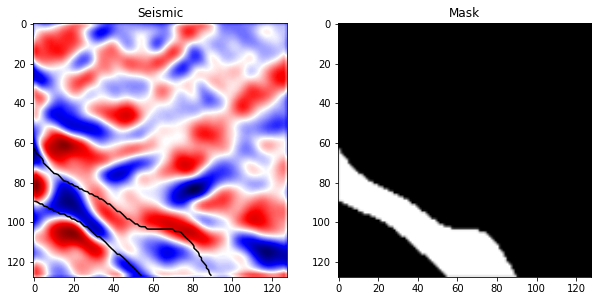

In [72]:
import random
import matplotlib.pyplot as plt
#Anzeigen von Plots direkt unter der Plot-generierenden Zelle
%matplotlib inline

# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Mask');

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [75]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))




Train on 2800 samples, validate on 800 samples
Epoch 1/100





2800/2800 [==============================] - 22s 8ms/step - loss: 0.5350 - acc: 0.7493 - val_loss: 0.4820 - val_acc: 0.7485

Epoch 00001: val_loss improved from inf to 0.48204, saving model to model-tgs-salt.h5
Epoch 2/100
2800/2800 [==============================] - 5s 2ms/step - loss: 0.4017 - acc: 0.8043 - val_loss: 0.3548 - val_acc: 0.8537

Epoch 00002: val_loss improved from 0.48204 to 0.35483, saving model to model-tgs-salt.h5
Epoch 3/100
2800/2800 [==============================] - 5s 2ms/step - loss: 0.3572 - acc: 0.8487 - val_loss: 0.3256 - val_acc: 0.8618

Epoch 00003: val_loss improved from 0.35483 to 0.32562, saving model to model-tgs-salt.h5
Epoch 4/100
2800/2800 [==============================] - 5s 2ms/step - loss: 0.3165 - acc: 0.8714 - val_loss: 0.3296 - val_acc: 0.8638

Epoch 00004: val_loss did not improve from 0.32562
Epoch 5/100
2800/2800 [==============================] - 5s 2ms/step - loss: 0.3120